### 8-10 Mercari Price Suggestion Challenge

In [3]:
!cd "/content/drive/My Drive/data"; ls -l

total 329893
-rw------- 1 root root 337809843 Feb 29 15:49 mercari_train.tsv


In [4]:
!cat /proc/meminfo;cat /proc/cpuinfo

MemTotal:       13335188 kB
MemFree:        10723196 kB
MemAvailable:   12503456 kB
Buffers:           75068 kB
Cached:          1854932 kB
SwapCached:            0 kB
Active:           721536 kB
Inactive:        1640056 kB
Active(anon):     404736 kB
Inactive(anon):      324 kB
Active(file):     316800 kB
Inactive(file):  1639732 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1160 kB
Writeback:             0 kB
AnonPages:        431692 kB
Mapped:           242864 kB
Shmem:               856 kB
Slab:             159964 kB
SReclaimable:     129396 kB
SUnreclaim:        30568 kB
KernelStack:        4128 kB
PageTables:         6088 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667592 kB
Committed_AS:    3075832 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

**데이터 전처리**

In [7]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df=pd.read_csv('/content/drive/My Drive/data/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [8]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


brand_name 칼럼의 경우 null값이 매우 많음

**타겟값의 분포 확인**

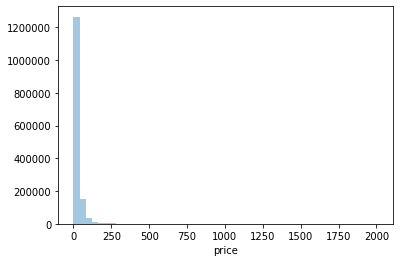

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df=mercari_df['price']
plt.figure(figsize=(6, 4))
sns.distplot(y_train_df, kde=False)

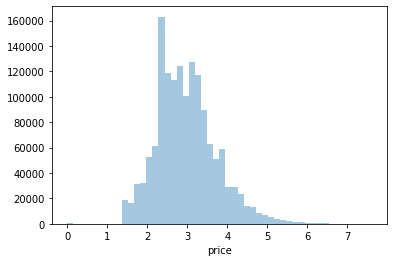

In [10]:
import numpy as np

y_train_df=np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

In [11]:
mercari_df['price']=np.log1p(mercari_df['price'])
mercari_df['price'].head()

0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

In [12]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts()) # 배송비 유무
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts()) 

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [13]:
boolean_cond=mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

In [0]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성. 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mecari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so']=zip(*mercari_df['category_name'].apply(lambda x:split_cat(x)))

In [16]:
print('대분류 유형:\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수:', mercari_df['cat_jung'].nunique())
print('소분류 개수:', mercari_df['cat_so'].nunique())

대분류 유형:
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 개수: 114
소분류 개수: 871


In [17]:
mercari_df['brand_name']=mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name']=mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description']=mercari_df['item_description'].fillna(value='Other_Null')

# 각 칼럼별로 Null값 건수 확인
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

**피처 인코딩과 피처 벡터화**

**brand name과 name의 종류 확인**

In [18]:
print('brand name의 유형 건수:', mercari_df['brand_name'].nunique()) # 원-핫 인코딩 변환하기
print('brand name sample 5건:\n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수: 4810
brand name sample 5건:
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


In [19]:
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

name 의 종류 갯수 : 1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


**item_description의 문자열 개수 확인**

In [20]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

**name은 Count로, item_description은 TF-IDF로 피처 벡터화**

In [21]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec=CountVectorizer()
X_name=cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp=TfidfVectorizer(max_features=50000, ngram_range=(1, 3), stop_words='english')
X_descp=tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


**사이킷런의 LabelBinarizer를 이용하여 원-핫 인코딩 변환 후 희소행렬 최적화 형태로 저장**

In [0]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name=LabelBinarizer(sparse_output=True)
X_brand=lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id=LabelBinarizer(sparse_output=True)
X_item_cond_id=lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping=LabelBinarizer(sparse_output=True)
X_shipping=lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae=LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [25]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


**피처 벡터화된 희소 행렬과 원-핫 인코딩된 희소 행렬을 모두 scipy 패키지의 hstack()함수를 이용하여 결합**

In [26]:
from scipy.sparse import hstack
import gc

sparse_matrix_list=(X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse=hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)


<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


**릿지 회귀 모델 구축 및 평가**

In [0]:
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
  # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복
  preds_exmpm=np.expm1(preds)
  y_test_exmpm=np.expm1(y_test)

  # rmsle로 RMSLE값 추출
  rmsle_result=rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

**여러 모델에 대한 학습/예측을 수행하기 위해 별도의 함수인 model_train_predict()생성**

해당 함수는 여러 희소 행렬을 hstack()으로 결합한 뒤 학습과 테스트 데이터 세트로 분할 후 모델 학습 및 예측을 수행

In [0]:
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  # scipy.sparse 모듈의 hstack을 이용해 희소행렬 결합
  X=hstack(matrix_list).tocsr()
  
  X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)
  
  # 모델 학습 및 예측
  model.fit(X_train, y_train)

  preds=model.predict(X_test)

  return preds, y_test

**릿지 선형 회귀로 학습/예측/평가. Item Description 피처의 영향도를 알아보기 위한 테스트 함께 수행**

In [29]:
linear_model=Ridge(solver="lsqr", fit_intercept=False)

sparse_matrix_list=(X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test=model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5023727038010544
Item Description을 포함한 rmsle 값: 0.4712195143433641


**LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가**

In [30]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

LightGBM rmsle 값: 0.45719580244261243


In [31]:
preds=lgbm_preds*0.45+linear_preds*0.55
print('LightGBM과 Ridge를 앙상블한 최종 RMSLE 값:', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 앙상블한 최종 RMSLE 값: 0.4507259214329315
